In [1]:
from collections.abc import Iterable
import pathlib
import numpy as np
import matplotlib.pyplot as plt

from qec_util.performance import plots, confidence_interval_binomial
from qec_util.samplers import read_failures_from_file
from surface_sim.models import PhenomenologicalDepolNoiseModel, PhenomenologicalNoiseModel
from lomatching import MoMatching

In [2]:
import matplotlib
import matplotlib.ticker as ticker

matplotlib.rcParams.update(
    {
        "font.size": 11,
        "font.family": "cmr10",
        "font.weight": "normal",
        'axes.unicode_minus': False,
        "axes.formatter.use_mathtext": True,
        "text.usetex": True,
        "axes.formatter.limits": (0,0),
    }
)

def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

int_to_alph = {i: s for i, s in enumerate("abcdefghijklmnopqrstuvwxyz")}

In [3]:
# INPUTS
EXPERIMENTS = ["CNOT-alternating"]
DISTANCES = [3, 5, 7]
PROBS = [
    0.005,
    0.01,
    0.01174619,
    0.0137973,
    0.01620657,
    0.01903654,
    0.02236068,
    0.02626528,
    0.03085169,
    0.03623898,
    0.042567,
    0.05,
]
NOISE_MODEL = PhenomenologicalDepolNoiseModel
BASES = ["Z"]
FRAMES = ["pre-gate"]
NUM_QEC_PER_GATE = 1
DECODER = MoMatching

# DATA STORAGE
NAME_FORMAT = "{exp_name}_{noise_model}_{decoder}_d{distance}_b{basis}_f{frame}_s0_ncycle-{ncycle}_p{prob:0.10f}.txt"
DATA_DIR = pathlib.Path("data")
PLOTS_DIR = pathlib.Path("plots")

In [5]:
if not PLOTS_DIR.exists():
    PLOTS_DIR.mkdir()

In [4]:
NUM_FAILURES = np.zeros((len(EXPERIMENTS), len(BASES), len(FRAMES), len(DISTANCES), len(PROBS)))
NUM_FAILURES_1 = np.zeros((len(EXPERIMENTS), len(BASES), len(FRAMES), len(DISTANCES), len(PROBS)))
NUM_FAILURES_2 = np.zeros((len(EXPERIMENTS), len(BASES), len(FRAMES), len(DISTANCES), len(PROBS)))
NUM_SAMPLES = np.zeros((len(EXPERIMENTS), len(BASES), len(FRAMES), len(DISTANCES), len(PROBS)))

for i, experiment_name in enumerate(EXPERIMENTS):
    for j, basis in enumerate(BASES):
        for k, frame in enumerate(FRAMES):
            for l, distance in enumerate(DISTANCES):
                for m, prob in enumerate(PROBS):
                    file_name = NAME_FORMAT.format(
                       exp_name=experiment_name,
                       noise_model=NOISE_MODEL.__name__,
                       distance=distance,
                       basis=basis,
                       frame=frame,
                       prob=prob,                       
                       decoder=DECODER.__name__,     
                       ncycle=NUM_QEC_PER_GATE,
                    )

                    if not (DATA_DIR / file_name).exists():
                        print("MISSING --", DATA_DIR / file_name)
                        continue
                    try:
                        num_failures, num_samples, extra = read_failures_from_file(DATA_DIR / file_name)
                    except:
                        print("Bad --", DATA_DIR / file_name)

                    if "I" == experiment_name:
                        NUM_FAILURES[i,j,k,l,m] = num_failures
                        NUM_SAMPLES[i,j,k,l,m] = num_samples
                    else:
                        NUM_FAILURES[i,j,k,l,m] = num_failures
                        NUM_FAILURES_1[i,j,k,l,m] = extra[2]
                        NUM_FAILURES_2[i,j,k,l,m] = extra[3]
                        NUM_SAMPLES[i,j,k,l,m] = num_samples
                        

LOG_PROB = NUM_FAILURES / NUM_SAMPLES
LOG_PROB_1 = NUM_FAILURES_1 / NUM_SAMPLES
LOG_PROB_2 = NUM_FAILURES_2 / NUM_SAMPLES
LOG_PROB_LOWER, LOG_PROB_UPPER = confidence_interval_binomial(NUM_FAILURES, NUM_SAMPLES)
LOG_PROB_LOWER_1, LOG_PROB_UPPER_1 = confidence_interval_binomial(NUM_FAILURES_1, NUM_SAMPLES)
LOG_PROB_LOWER_2, LOG_PROB_UPPER_2 = confidence_interval_binomial(NUM_FAILURES_2, NUM_SAMPLES)

In [5]:
print((NUM_SAMPLES != 0).sum())
assert (NUM_SAMPLES != 0).all()

36


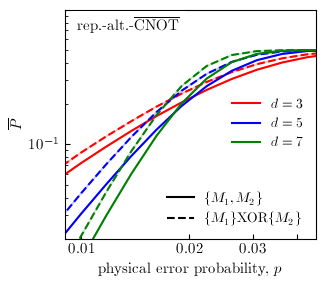

In [6]:
fig, axes = plt.subplots(ncols=len(EXPERIMENTS), figsize=cm2inch(8, 7))

if not isinstance(axes, Iterable):
    axes = [axes]

for i, experiment_name in enumerate(EXPERIMENTS):
    ax = axes[i]

    color_distances_frame = [["red", "blue", "green", "purple"]] 
    for k, frame in enumerate(FRAMES):
        color_distances = color_distances_frame[k]
        for j, basis in enumerate(BASES):
            for l, distance in enumerate(DISTANCES):
                if experiment_name == "I":
                    ax.plot(PROBS, LOG_PROB[i,j,k,l], "-", color=color_distances[l])
                    ax.fill_between(PROBS, LOG_PROB_LOWER[i,j,k,l], LOG_PROB_UPPER[i,j,k,l], color=color_distances[l], alpha=0.2)
                else:
                    ax.plot(PROBS, LOG_PROB_1[i,j,k,l], "-", color=color_distances[l])
                    ax.fill_between(PROBS, LOG_PROB_LOWER_1[i,j,k,l], LOG_PROB_UPPER_1[i,j,k,l], color=color_distances[l], alpha=0.2)
                    ax.plot(PROBS, LOG_PROB_2[i,j,k,l], "--", color=color_distances[l])
                    ax.fill_between(PROBS, LOG_PROB_LOWER_2[i,j,k,l], LOG_PROB_UPPER_2[i,j,k,l], color=color_distances[l], alpha=0.2)
            
    if experiment_name == "CNOT-alternating":
        name = "rep.-alt.-$\\overline{\\mathrm{CNOT}}$"
    elif experiment_name == "CNOT-no-alternating":
        name = "rep.-$\\overline{\\mathrm{CNOT}}$"
    else:
        name = f"rep.-$\\overline{{{experiment_name}}}$"

    xmin, xmax = 0.9e-2, 4.5e-2

    if "CNOT" not in experiment_name:
        ymin, ymax = 2e-2, 0.99999999
    else:
        ymin, ymax = 2e-2, 0.99999999
    ax.set_xlim(xmin, xmax)
    ax.set_yticks([1e-2, 1e-1])
    ax.set_ylim(ymin, ymax)
    ax.text(xmin*1.085, ymax/1.4, f"{name}", bbox=dict(facecolor='white', edgecolor='none', pad=4.0))
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylabel("$\\overline{P}$")
    ax.tick_params(direction="in", which="major")
    ax.tick_params(direction="in", which="minor")
    
    if i != 0:
        ax.set_ylabel("")
        ax.set_yticklabels([])

    ax.set_xlabel("physical error probability, $p$")
    xticks = [0.01, 0.02, 0.03, 0.04]
    xticklabels = ["0.01", "0.02", "0.03", ""]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)


ax = axes[0]
lines = []
for l, distance in enumerate(DISTANCES):
    line, = ax.plot([], [], color=color_distances[l], linestyle="-", label=f"$d = {distance}$")
    lines.append(line)
legend = ax.legend(handles=lines, loc="center right", fontsize=10, frameon=False)
ax.add_artist(legend)

ax = axes[0]
line1, = ax.plot([], [], color="black", linestyle="-", label="$\\{M_1, M_2\\}$")
line2, = ax.plot([], [], color="black", linestyle="--", label="$\\{M_1\\} \\mathrm{XOR} \\{M_2\\}$")
ax.legend(handles=[line1, line2], loc="lower right", fontsize=10, frameon=False)

fig.tight_layout(pad=0.30)
plt.subplots_adjust(wspace=.0)
fig.savefig(PLOTS_DIR / "threshold_plot_repeated_exp_phen-depol-noise_cnot_z1z2.pdf", format="pdf")
plt.show()